# Multiverse Technical Assessment

## Creating a realistic time series forecasting tool

<div style="text-align: right">Oussama Tahiri Alaoui, 08-07-2021</div>

## Contents

- [1. Introduction](#1)
- [2. Dependencies](#2)
- [3. Extracting data](#3)
- [4. Univariate CNN model](#4)
    - [4.1. Data preparation](#4-1)
    - [4.2. Train/Test split](#4-2)
    - [4.3. One-dimensional CNN model](#4-3)
    - [4.4. Make the prediction](#4-4)
    - [4.5. Parameters tunning](#4-5)
- [5. ARIMA Model](#5)
    - [5.1. Format the data](#5-1)
    - [5.2. Stationarize the data](#5-2)
    - [5.3. Train/Test split](#5-3)
    - [5.4. Build ARIMA model](#5-4)
    - [5.5. Make the prediction](#5-5)
- [6. Conclusion](#6)
- [References](#7)

<a name='1'></a>
## 1. Introduction

Most of the data that is collected has a temporal structure and knowing how to model time series is an essential skill within data science.
An example of this data is the market stocks where investors are always taking risks in hopes of making a profit. Predicting the price of a specific stock one day ahead is a big competitive move, but a complex task.

In this notebook, we are going to predict the price of the Bitcoin USD (BTC-USD) using two different approaches, 1D Convolutional Neural Network (CNN) and an ARIMA model.

<a name='2'></a>
## 2. Dependencies

First, we import all the Python packages that we need to tackle this task. Also, IPython helper command for plots outputs to appear and be stored within the notebook.

In [ ]:
# importing needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

Using TensorFlow backend.


- `numpy` is a library that supports large, multi-dimensional arrays and matrices, mathematical functions to operate on these arrays.
- `pandas` is a fast and easy-to-use data analysis and manipulation tool.
- `matplotlib` is a plotting library.
- `yfinance` a library offering a reliable way to download historical market data from Yahoo! finance.
- `sklearn` contains simple and efficient tools for predictive data analysis.
- `keras` is a high-level API of TensorFlow 2 for solving machine learning problems, with a focus on modern deep learning.
- `statsmodels` is a Python module that provides classes and functions for the estimation of many different statistical models.

<a name='3'></a>
## 3. Extracting Data

To obtain the Bitcoin USD (BTC-USD) prices data, we will use the yfinance the following way:

In [3]:
# use Ticker module, to access ticker data in a more Pythonic way
btc = yf.Ticker("BTC-USD")

# to get stock info
print(btc.info['description'])

Bitcoin (BTC) is a cryptocurrency . Users are able to generate BTC through the process of mining. Bitcoin has a current supply of 18,750,962. The last known price of Bitcoin is 32,678.6298633 USD and is down -6.09 over the last 24 hours. It is currently trading on 9142 active market(s) with $28,575,653,148.76 traded over the last 24 hours. More information can be found at https://bitcoin.org/.


In [4]:
# get historical market data as dataframe
hist = btc.history(period="max")
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0
...,...,...,...,...,...,...,...
2021-07-04,34665.566406,35937.566406,34396.476562,35287.781250,24924307911,0,0
2021-07-05,35284.343750,35284.343750,33213.660156,33746.003906,26721554282,0,0
2021-07-06,33723.507812,35038.535156,33599.917969,34235.195312,26501259870,0,0


Checking the columns type:

In [5]:
hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2483 entries, 2014-09-17 to 2021-07-08
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          2483 non-null   float64
 1   High          2483 non-null   float64
 2   Low           2483 non-null   float64
 3   Close         2483 non-null   float64
 4   Volume        2483 non-null   int64  
 5   Dividends     2483 non-null   int64  
 6   Stock Splits  2483 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 155.2 KB


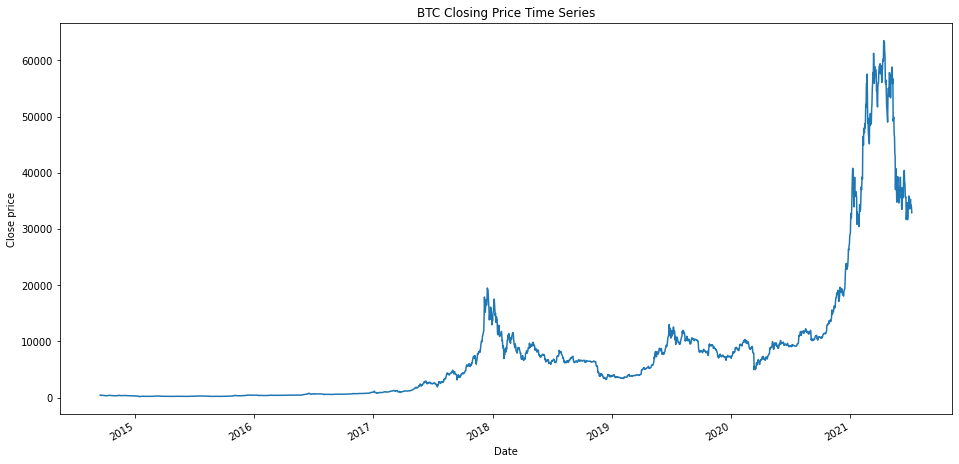

In [6]:
plt.figure(figsize=(16,8))
hist['Close'].plot()
plt.title('BTC Closing Price Time Series')
plt.xlabel('Date')
plt.ylabel('Close price')
plt.show()

<a name='4'></a>
## 4. Univariate CNN Model

Although traditionally developed for two-dimensional image data, CNNs can be used to model univariate time series forecasting problems.
We chose to use the closing value of BTC price for our analysis which means we are using a type of data that consists of observations on only a single characteristic (Univariate).
Univariate time series are datasets comprised of a single series of observations with a temporal ordering (daily in our case) and the model is required to learn from the series of past observations to predict the next value in the sequence.
The workflow for CNN model will be:
- Prepare the data.
- Train/Test split.
- Fit the CNN model.
- Make the prediction.
- Tune the model parameters.

<a name='4-1'></a>
### 4.1. Data Preparation

We extract the column of the closing price that we are going to work with:

In [7]:
data = pd.DataFrame(hist['Close'])
data

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2021-07-04,35287.781250
2021-07-05,33746.003906
2021-07-06,34235.195312


We apply the MinMaxScaler to the data directly to normalize the input variable by using scale values to the range between -1 and 1. First, a MinMaxScaler instance is defined with default hyperparameters. Once defined, we can call the fit_transform() function and pass it to our dataset to create a transformed version of our dataset.

In [8]:
# extract values as list
btc_values = data.values
# btc_values = btc_values.astype('float32')

# perform a robust scaler transform of the dataset
scaler = MinMaxScaler(feature_range=(-1,1))
btc_values_ts = scaler.fit_transform(btc_values)

The CNN model will learn a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the model can learn.
We divide the sequence of values into multiple input/output patterns called samples, where a number of time steps are used as input and a one-time step is used as output for the one-step prediction that is being learned.
The `split_sequence()` function below implements this behavior and will split our univariate sequence into multiple samples where each sample has a specified number of time steps and the output is a single time step.

In [9]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        
        # find the end of this pattern
        end_ix = i + n_steps
        
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
            
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

Running the splits one our univariate sequence:

In [10]:
# number of features
n_features = 1

# choose a number of time steps
n_steps = 30

# split into samples
X, y = split_sequence(btc_values_ts, n_steps)

# summarize the data
# for i in range(3):
#     print(X[i], y[i])

We check the lenght of sequence after spliting:

In [11]:
len(X)

2453

<a name='4-2'></a>
### 4.2. Train/Test split

Now we have to split our dataset into training and testing subsets.
Depending on the amount of data we have available we can use splits of 70% training data and 30% testing data.
It is straightforward to split data in Python:

In [12]:
train_size = int(len(X) * 0.70)
Xtrain, ytrain = X[0:train_size], y[0:train_size]
Xtest, ytest = X[train_size:len(X)], y[train_size:len(X)]
print('Total data: %d' % (len(X)))
print('Training data: %d' % (len(Xtrain)))
print('Testing data: %d' % (len(Xtest)))

Total data: 2453
Training data: 1717
Testing data: 736


<a name='4-3'></a>
### 4.3. One-dimensional CNN model

A one-dimensional CNN is a CNN model that has a convolutional hidden layer that operates over a 1D sequence. It can be followed by a second convolutional layer and then a pooling layer to distill the output of the convolutional layer to the most salient elements.

The convolutional and pooling layers are followed by a dense fully connected layer that interprets the features extracted by the convolutional part of the model. A flattening layer is used between the convolutional layers and the dense layer to reduce the feature maps to a single one-dimensional vector.

In [13]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [14]:
# fit model
model.fit(Xtrain, ytrain, epochs=500, verbose=0)

<a name='4-4'></a>
### 4.4. Make the prediction

In [15]:
# demonstrate prediction
preds = model.predict(Xtest)
preds = scaler.inverse_transform(preds)

ytest_ts = np.asanyarray(ytest)
ytest_ts = ytest_ts.reshape(-1,1)
ytest_ts = scaler.inverse_transform(ytest_ts)

ytrain_ts = np.asanyarray(ytrain)
ytrain_ts = ytrain_ts.reshape(-1,1) 
ytrain_ts = scaler.inverse_transform(ytrain_ts)

print('Testing Mean Squared Error is: {}'.format(mean_squared_error(ytest_ts, preds)))

Testing Mean Squared Error is: 113467760.36807957


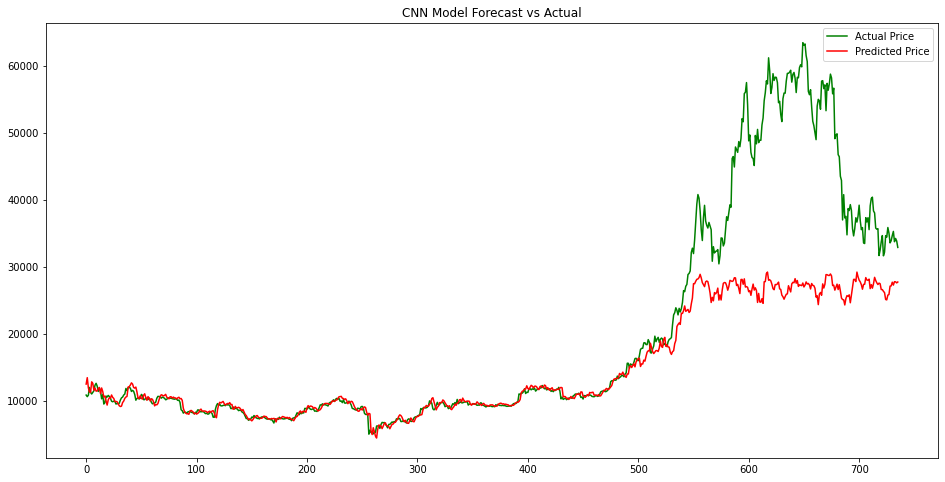

In [16]:
plt.figure(figsize=(16,8))
plt.title('CNN Model Forecast vs Actual')
plt.plot(ytest_ts, color='green', label='Actual Price')
plt.plot(preds, 'r', label='Predicted Price')
plt.legend()
plt.show()

<a name='4-5'></a>
### 4.5. Parameters tunning

In [17]:
# define model
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(Xtrain, ytrain, epochs=500, verbose=0)

In [18]:
# demonstrate prediction
preds = model.predict(Xtest)
preds = scaler.inverse_transform(preds)

ytest_ts = np.asanyarray(ytest)
ytest_ts = ytest_ts.reshape(-1,1) 
ytest_ts = scaler.inverse_transform(ytest_ts)

ytrain_ts = np.asanyarray(ytrain)
ytrain_ts = ytrain_ts.reshape(-1,1) 
ytrain_ts = scaler.inverse_transform(ytrain_ts)

print('Testing Mean Squared Error is: {}'.format(mean_squared_error(ytest_ts, preds)))

Testing Mean Squared Error is: 118016841.48294024


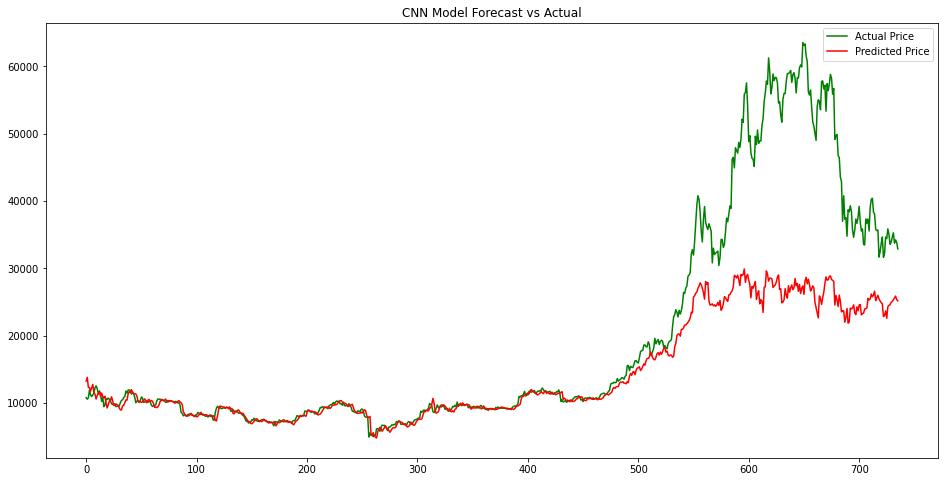

In [19]:
plt.figure(figsize=(16,8))
plt.title('CNN Model Forecast vs Actual')
plt.plot(ytest_ts, color='green', label='Actual Price')
plt.plot(preds, 'r', label='Predicted Price')
plt.legend()
plt.show()

<a name='5'></a>
## 5. ARIMA Model

To predict an outcome based on time series data, we can use a time series model which is called Auto Regressive Integrated Moving Average (ARIMA).
This model is used as the machine learning technique to analyze and predict future stock prices based on historical prices.
We chose to use the closing value of BTC price for our analysis. The workflow for the ARIMA model will be:
- Format the data.
- Stationarize the data.
- Train/Test split.
- Build the ARIMA model.
- Make the prediction.

<a name='5-1'></a>
### 5.1. Format the data

In [20]:
data = pd.DataFrame(hist['Close'])
data

,Close
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2021-07-04,35287.781250
2021-07-05,33746.003906
2021-07-06,34235.195312


<a name='5-2'></a>
### 5.2. Stationarize the data

We have to check if our time series is stationary or not because the ARIMA model works best with stationary data. There are two ways to determine whether a given time series is stationary:
- Rolling Statistics: Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time as we look to see if the lines are straight and parallel to the x-axis.
- Augmented Dickey-Fuller Test: The time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistics.

`test_stationarity` is a function to run the two tests and show the test results:

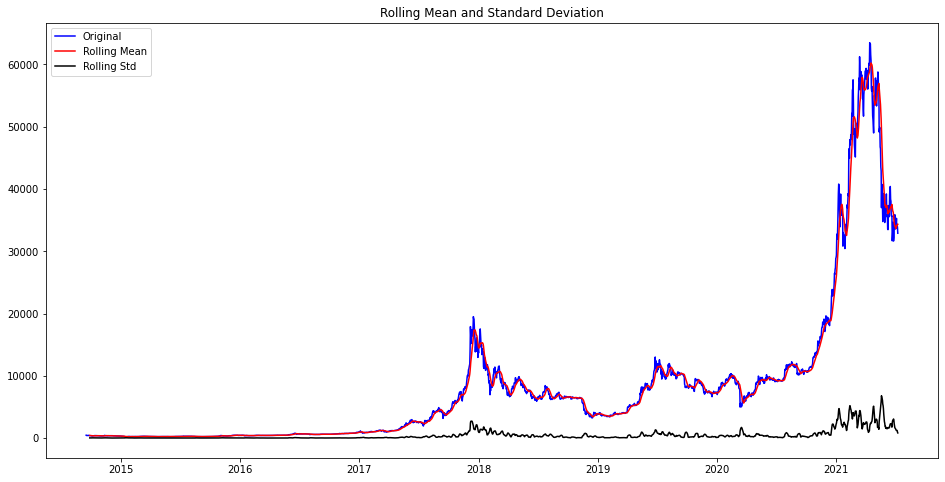

Results of dickey fuller test
Test Statistics                  -0.859088
p-value                           0.801147
No. of lags used                 26.000000
Number of observations used    2456.000000
critical value (1%)              -3.433015
critical value (5%)              -2.862718
critical value (10%)             -2.567397
dtype: float64

 Weak evidence against null hypothesis, indicating it is non-stationary!


In [21]:
# testing for stationarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Plot rolling statistics:
    plt.figure(figsize=(16,8))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend()
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()
    
    print("Results of dickey fuller test")
    result = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(result[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in result[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    if result[1] <= 0.05:
        print("\n Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary!")
    else:
        print("\n Weak evidence against null hypothesis, indicating it is non-stationary!")
    
test_stationarity(data)

Also, the rolling mean and rolling standard deviation increase with time. Therefore, we can conclude that the time series is not stationary.
Taking the log of the dependent variable is a simple way of lowering the rate at which rolling mean increases.

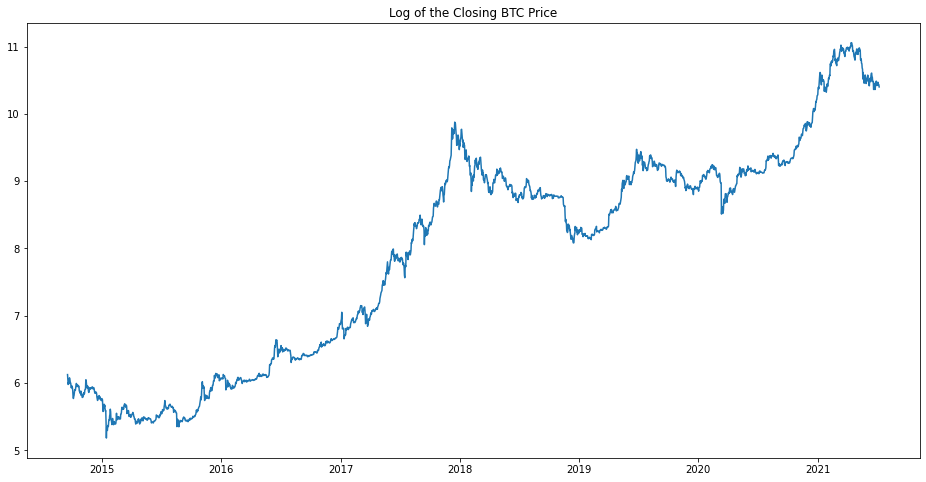

In [22]:
data_log = np.log(data)
plt.figure(figsize=(16,8))
plt.title('Log of the Closing BTC Price')
plt.plot(data_log)

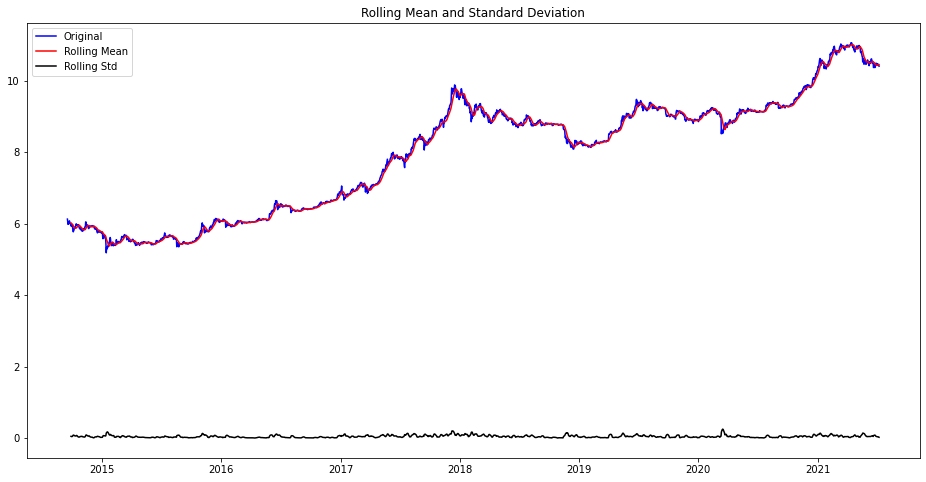

Results of dickey fuller test
Test Statistics                  -0.322687
p-value                           0.922229
No. of lags used                 10.000000
Number of observations used    2472.000000
critical value (1%)              -3.432998
critical value (5%)              -2.862710
critical value (10%)             -2.567393
dtype: float64

 Weak evidence against null hypothesis, indicating it is non-stationary!


In [23]:
test_stationarity(data_log)

There are multiple transformations that we can apply to our time series to make it stationary. For instance, we subtract the rolling mean:

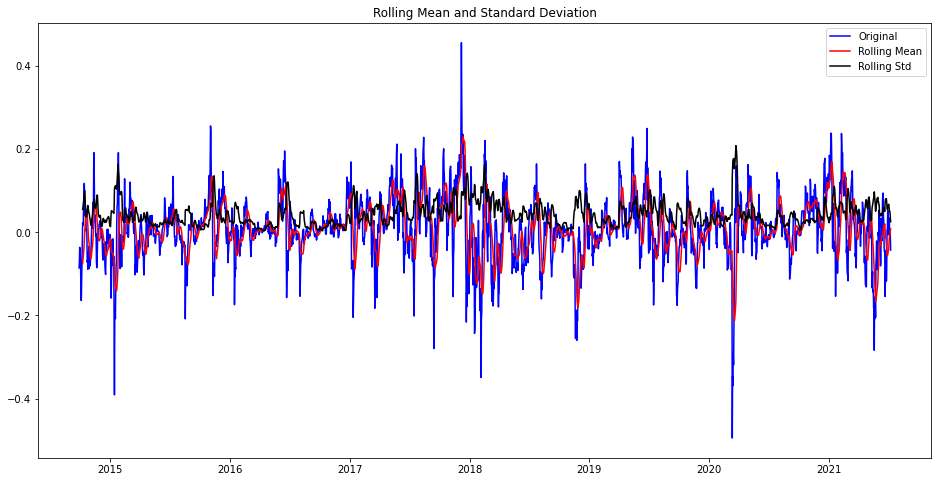

Results of dickey fuller test
Test Statistics               -1.025952e+01
p-value                        4.272885e-18
No. of lags used               1.100000e+01
Number of observations used    2.460000e+03
critical value (1%)           -3.433011e+00
critical value (5%)           -2.862716e+00
critical value (10%)          -2.567396e+00
dtype: float64

 Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary!


In [24]:
rolling_mean = data_log.rolling(window=12).mean()
data_log_minus_mean = data_log - rolling_mean
data_log_minus_mean.dropna(inplace=True)
test_stationarity(data_log_minus_mean)

<a name='5-3'></a>
### 5.3. Train/Test split

Total data: 2472
Training data: 1730
Testing data: 742


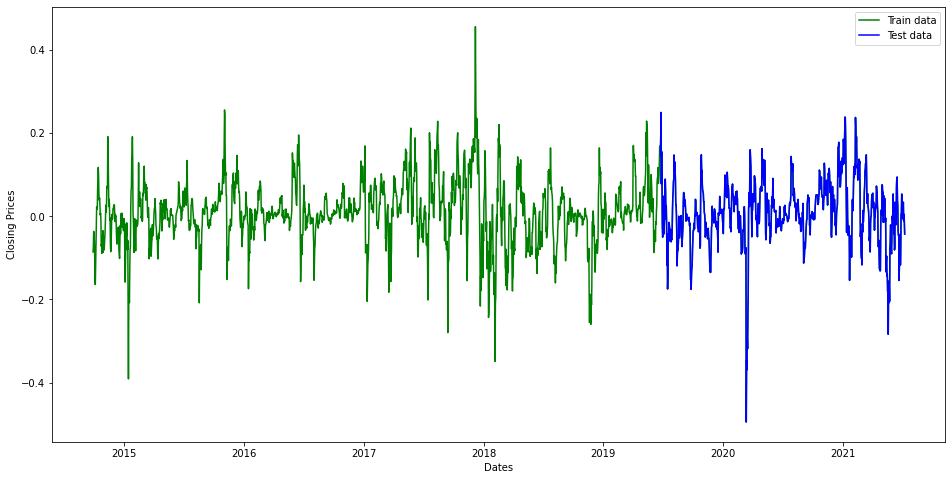

In [26]:
# split data into train and training set
train_data, test_data = data_log_minus_mean[:int(len(data_log_minus_mean)*0.7)], data_log_minus_mean[int(len(data_log_minus_mean)*0.7):]
plt.figure(figsize=(16,8))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(data_log_minus_mean, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
print('Total data: %d' % (len(data_log_minus_mean)))
print('Training data: %d' % (len(train_data)))
print('Testing data: %d' % (len(test_data)))

It's time to choose the parameters p,q,d for the ARIMA model. We are going to use Auto ARIMA to get the best parameters.
Auto ARIMA automatically discovers the optimal order for an ARIMA model identifying the most optimal parameters for an ARIMA model and returns a fitted ARIMA model.

In [27]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-4054.627, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-6626.291, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5407.612, Time=0.22 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-6630.094, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-6630.249, Time=0.19 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-6626.329, Time=0.26 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-6637.338, Time=0.50 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-6629.689, Time=0.17 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-6635.771, Time=0.84 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-6629.220, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.16 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-6638.009, Time=0.96 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-6630.017, Time=0.40 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-6630.455, Time=0.18 sec
 ARIMA(3,0,1)(0,0,0)[0] i

<a name='5-4'></a>
### 5.4. Build ARIMA model

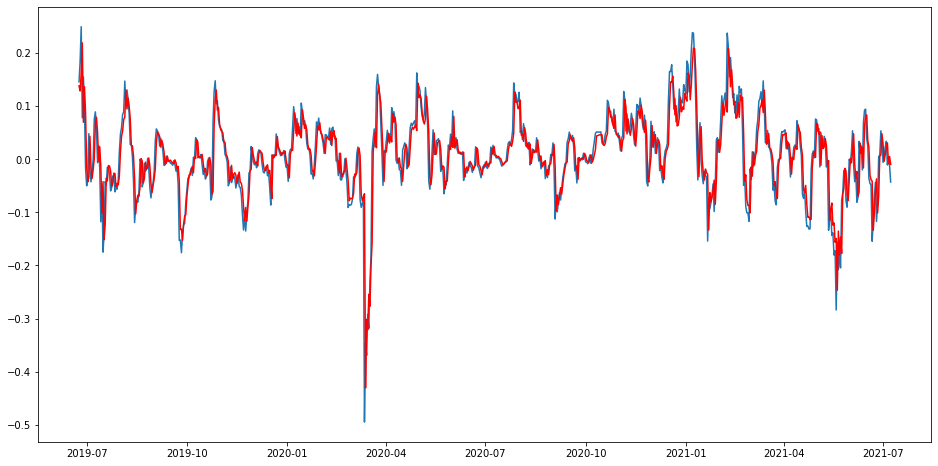

In [31]:
model = ARIMA(data_log_minus_mean, order=(2,0,1))
results = model.fit()
prediction = results.fittedvalues[len(train_data):]
plt.figure(figsize=(16,8))
plt.plot(test_data)
plt.plot(prediction, color='red')

In [32]:
MSE_error = mean_squared_error(test_data, prediction)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 0.0014961830042861325


<a name='5-5'></a>
### 5.5. Make the prediction

Testing Mean Squared Error is: 1214559.905244791


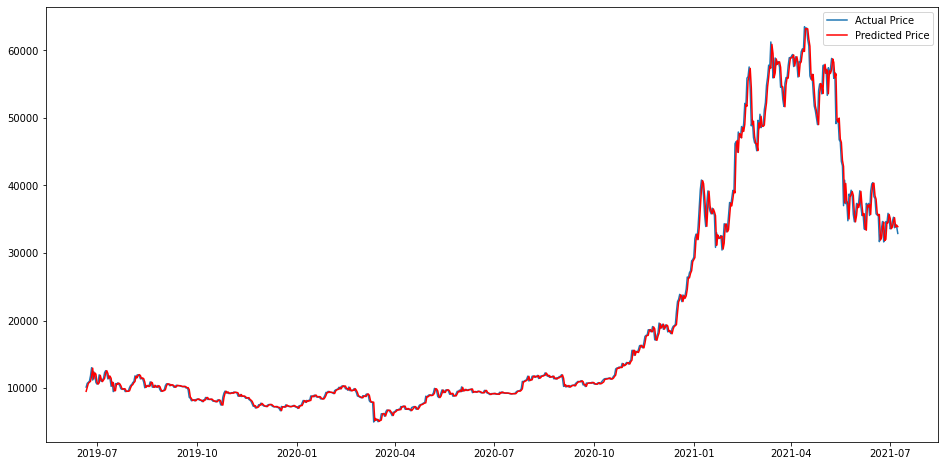

In [33]:
train_data, test_data = data[:int(len(data)*0.7)], data[int(len(data)*0.7):]
model = ARIMA(data, order=(2,0,1))
results = model.fit()
prediction = results.fittedvalues[len(train_data):]
plt.figure(figsize=(16,8))
plt.plot(test_data, label='Actual Price')
plt.plot(prediction, color='red', label='Predicted Price')
plt.legend()
MSE_error = mean_squared_error(test_data, prediction)
print('Testing Mean Squared Error is: {}'.format(MSE_error))

<a name='6'></a>
## 6. Conlusion

We had a quick look into two approaches for time series forecasting, 1D CNN model and ARMIA using a univariate time series, where the ARIMA model performed better looking at the Mean Squared Error for both predictions. To have an in-depth comparison between the models we have to work with multivariate and multi-step time series and use multiple train-test splits or walk-forward validation to evaluate our models.

## References
- https://github.com/ranaroussi/yfinance
- https://scikit-learn.org/0.21/documentation.html
- https://machinelearningmastery.com